# Modelo Autoregressivo Vetorial

Utilizando modelo VAR para modelar a série temporal

* Importando biblitecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

* Lendo arquivo Excel

In [2]:
dados = pd.read_excel('AirQualityUCI.xlsx')

* Exibindo cinco primeiras linhas

In [3]:
dados.head()

Date      Time      T         RH
0 2004-03-10  18:00:00  13.60  48.875001
1 2004-03-10  19:00:00  13.30  47.700000
2 2004-03-10  20:00:00  11.90  53.975000
3 2004-03-10  21:00:00  11.00  60.000000
4 2004-03-10  22:00:00  11.15  59.575001

* Unindo data e hora numa mesma coluna

In [4]:
dados['Date_Time'] = dados['Date'].astype(str)+" "+ dados['Time'].astype(str)

* Convertendo Date_Time para tipo datetime

In [5]:
dados['Date_Time'] = pd.to_datetime(dados['Date_Time']) 

* Removendo colunas Date e Time

In [6]:
dados = dados.drop(['Date','Time'],axis=1)

* Definindo Date_Time como índice

In [7]:
dados = dados.set_index('Date_Time')

* Graficando séries temporais

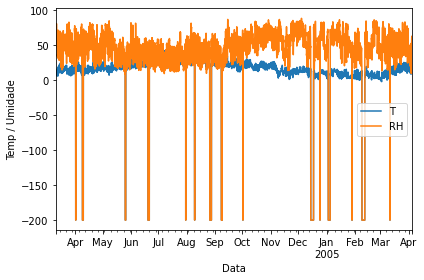

In [8]:
dados.plot()
plt.xlabel('Data')
plt.ylabel('Temp / Umidade')
plt.tight_layout()

* Removendo valores de umidade negativos

In [9]:
dados = dados[dados['RH']>0]

* Amostragem diária com média dos valores

In [10]:
dados =  dados.resample('D').median()
dados= dados.dropna()

* Graficando séries temporais

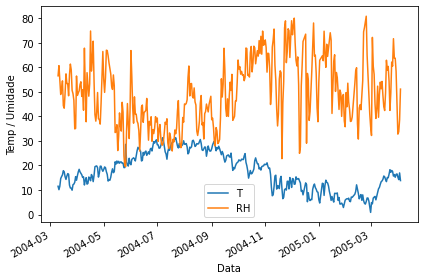

In [11]:
dados.plot()
plt.xlabel('Data')
plt.ylabel('Temp / Umidade')
plt.tight_layout()

* Realizando teste de Granger

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests

In [13]:
granger = grangercausalitytests(dados, maxlag=5, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5407  , p=0.1118  , df_denom=379, df_num=1
ssr based chi2 test:   chi2=2.5608  , p=0.1095  , df=1
likelihood ratio test: chi2=2.5522  , p=0.1101  , df=1
parameter F test:         F=2.5407  , p=0.1118  , df_denom=379, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.6061  , p=0.0015  , df_denom=376, df_num=2
ssr based chi2 test:   chi2=13.3879 , p=0.0012  , df=2
likelihood ratio test: chi2=13.1581 , p=0.0014  , df=2
parameter F test:         F=6.6061  , p=0.0015  , df_denom=376, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2586  , p=0.0015  , df_denom=373, df_num=3
ssr based chi2 test:   chi2=16.0718 , p=0.0011  , df=3
likelihood ratio test: chi2=15.7412 , p=0.0013  , df=3
parameter F test:         F=5.2586  , p=0.0015  , df_denom=373, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8834  , p=0.0008  

* Verificando se a série é estacionária com o teste ADF

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
def adfuller_test(series, signif=0.05, name=''):
    r = adfuller(series, autolag='AIC')
    
    saida = {'teste_estatistico':round(r[0], 4), 'valor-p':round(r[1], 4), 'n_atrasos':round(r[2], 4), 'n_obs':r[3]}
    valor_p = saida['valor-p'] 
    
    print("Hipótese nula: Dado tem raiz unitária. Não estacionária")
    print("Nivel de significancia = {}".format(signif))
    print("Teste estatístico = {}".format(saida["teste_estatistico"]))
    print("Atrasos escolhidos = {}".format(saida["n_atrasos"]))
    
    for key,val in r[4].items():
        print("Valor crítico {} = {}".format(key,round(val,3)))
    
    if(valor_p<=signif):
        print("Valor-p = {}. Rejeitando hipótese nula".format(valor_p))
        print("Série é estacionária")
    else:
        print("Valor-p = {}. Fraca evidência para rejeitar a hipótese nula".format(valor_p))
        print("Série não é estacionária")

In [16]:
for name, column in dados.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Hipótese nula: Dado tem raiz unitária. Não estacionária
Nivel de significancia = 0.05
Teste estatístico = -1.514
Atrasos escolhidos = 5
Valor crítico 1% = -3.448
Valor crítico 5% = -2.869
Valor crítico 10% = -2.571
Valor-p = 0.5266. Fraca evidência para rejeitar a hipótese nula
Série não é estacionária


Hipótese nula: Dado tem raiz unitária. Não estacionária
Nivel de significancia = 0.05
Teste estatístico = -5.6345
Atrasos escolhidos = 2
Valor crítico 1% = -3.448
Valor crítico 5% = -2.869
Valor crítico 10% = -2.571
Valor-p = 0.0. Rejeitando hipótese nula
Série é estacionária




* Separando em treino e teste

In [17]:
t_treino = dados[dados.index<'2005-02-01'].index.values
t_teste = dados[dados.index>='2005-02-01'].index.values
X_treino = (dados[dados.index<'2005-02-01'].values)
X_teste = (dados[dados.index>='2005-02-01'].values)

* Aplicando modelo VAR

In [18]:
from statsmodels.tsa.api import VAR

In [19]:
modelo = VAR(np.log(X_treino))

In [20]:
lags = list(range(1,11))

AIC_tmp = -5
for lag in lags:
    resultado = modelo.fit(lag)
    print("Lag = {}, AIC = {}".format(lag,resultado.aic))
    if(AIC_tmp > resultado.aic):
        lag_tmp = lag
        AIC_tmp = resultado.aic
        
print("Best Lag = {}".format(lag_tmp))

Lag = 1, AIC = -7.04773393155594
Lag = 2, AIC = -7.0700773904564596
Lag = 3, AIC = -7.143607928404706
Lag = 4, AIC = -7.1710379819387375
Lag = 5, AIC = -7.170705542821439
Lag = 6, AIC = -7.142149808422196
Lag = 7, AIC = -7.153158034583764
Lag = 8, AIC = -7.133236133346188
Lag = 9, AIC = -7.128554852787882
Lag = 10, AIC = -7.113745354059591
Best Lag = 4


In [21]:
resultado = modelo.fit(lag_tmp)

In [22]:
ordem_atraso = resultado.k_ar

In [23]:
entrada_predicao = X_treino[-ordem_atraso:]

In [24]:
X_pred = resultado.forecast(y=entrada_predicao,steps=len(X_teste))

In [25]:
X_treino1 = X_treino[:,0]
X_treino2 = X_treino[:,1]
X_teste1 = X_teste[:,0]
X_teste2 = X_teste[:,1]
X_pred1 = X_pred[:,0]
X_pred2 = X_pred[:,1]

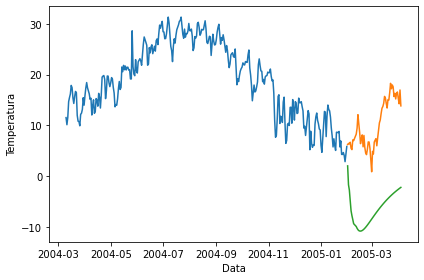

In [26]:
plt.plot(t_treino,X_treino1)
plt.plot(t_teste,X_teste1)
plt.plot(t_teste,X_pred1)
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.tight_layout()

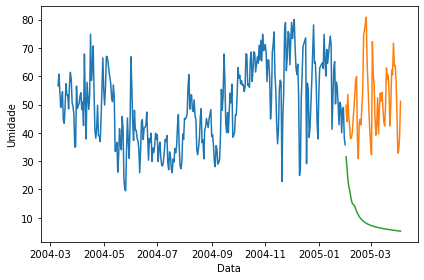

In [27]:
plt.plot(t_treino,X_treino2)
plt.plot(t_teste,X_teste2)
plt.plot(t_teste,X_pred2)
plt.xlabel('Data')
plt.ylabel('Umidade')
plt.tight_layout()